In [ ]:
# only used for debugging the dynamic rescoring method
import pandas as pd
import numpy as np


def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    This function credits to https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            ##### Key statement: Check if two columns at x and y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)


# check if cl files of different iterations are the same...
def check_if_duplicates(file_path_prefix, iteration_num):
    iterations = 200 * np.arange(1, 1+iteration_num)
    for iter in iterations:
        if iter == 200:
            df = pd.read_csv(file_path_prefix + str(iter), names=["preds_dif_"+str(iter)])
        else:
            df["preds_dif_" + str(iter)] = pd.read_csv(file_path_prefix + str(iter), names=["preds_dif_"+str(iter)])

    # Get list of duplicate columns
    duplicateColumnNames = getDuplicateColumns(df)
    print('Duplicate Columns are as follows')
    for col in duplicateColumnNames:
        print('Column name : ', col)

    # # Delete duplicate columns
    # newDf = df.drop(columns=getDuplicateColumns(df))
    # print("Modified Dataframe", newDf, sep='\n')


path = "06-14/ms_v2_dynamic_cl_unchange_root_2_seed_1/"
file_name_prefix = "preds_run_cl_preds_dif_root_2_seed_1_iter_"
#check_if_duplicates(path + file_name_prefix, 10)


# Functions for getting validating MAP and plot the results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter

def read_eval_results(length, result_path):
    res = []
    incomplete = False
    with open(result_path,'r', encoding="utf8") as f:
        for line in f:
            line = line[:-1]
            map_val = float(line.split("map = ")[1])
            res.append(map_val)
    if len(res) < length:
        incomplete = True
    if len(res) > length:
        res = res[:length]  
    return res, incomplete


def get_all_results(path, dataset_names, scoring_func_names, seeds, length):
    res = {}
    for dataset in dataset_names:
        for scoring_func in scoring_func_names:
            for seed in seeds:
                try:
                    result_path = f"{path}/{dataset}_{scoring_func}_seed_{seed}/eval_results.txt"
                    tmp, incomplete = read_eval_results(length, result_path)
                    if dataset_names == ['mantis_10']:
                        seed = seed.split('_')[0]
                    if incomplete:
                        print(f"file {result_path} lacks {length - len(tmp)} iterations")
                        for _ in range(length - len(tmp)):
                            tmp.append(tmp[-1])
                    if seed == '1':
                        new = tmp
                    else:
                        new = np.vstack((new, tmp))
                except:
                    print('No such file:', result_path)
            if len(seeds) > 1:
                new = np.mean(new, axis = 0)
            res[scoring_func] = new
    return res


def plot_with_max(res_df, title, x, yb = 0.5, yh = 0.7, legend_size=18):
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_subplot()
 
    color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'grey', 'magenta', 'cyan', 'violet'] 
    scoring_funcs = list(res_df.columns)

    for i in range(len(scoring_funcs)):
        y = res_df[scoring_funcs[i]]
        line, = ax.plot(x, y, color = color[i])
        ymax = max(y)
        xpos = np.where(y == ymax)[0][0]
        xmax = x[xpos]
        ax.annotate(text='max', xy=(xmax, ymax), xytext=(xmax, ymax),
                    arrowprops=dict(facecolor=color[i], shrink = 0.05, width=0.01))

    ax.legend(scoring_funcs, loc='best', prop={'size': legend_size})
    ax.set_ylim(yb, yh)
    ax.set_xlim(x[0], x[-1]+50, 100)
    ax.set_xlabel('Iterations', fontsize = 14)
    ax.set_ylabel('Mean average precision', fontsize = 14)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if title != '':
        ax.set_title(title, fontsize = 16)
    plt.show()   


def iterations(num, logging_step):
    return np.arange(1, num + 1) * logging_step

              

# Illustrations of the methods with figures

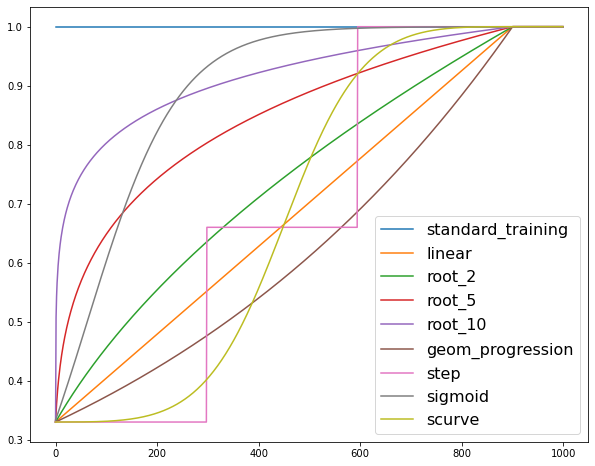

In [ ]:
# x=global_step, t=curriculum_iterations*total_steps 0.90*1000, c0=0.33
def linear(x, t, c0):
	return (x* ((1-c0)/t)) + c0

def root_2(x, t, c0):
	return ((x* ((1-(c0**2.0))/t)) + (c0**2.0))**(1./2)

def root_5(x, t, c0):
	return ((x* ((1-(c0**5.0))/t)) + (c0**5.0))**(1./5)

def root_10(x, t, c0):
	return ((x* ((1-(c0**10.0))/t)) + (c0**10.0))**(1./10)

def geom_progression(x, t, c0):
	return 2.0**((x* ((math.log(1,2.0)-math.log(c0,2.0))/t)) +math.log(c0,2.0))

def step(x, t, c0):
	if x <= t*0.33:
		return 0.33 
	elif x> t*0.33 and x<= t*0.66:
		return 0.66 
	else:
		return 1

def standard_training(x, t, c0):
	return 1
    
def sigmoid(x, t, c0):
  k = 10
  return 1/(1 + np.exp(-k * (x/t) + math.log(2)))

def s_curve(x, t, c0):
  beta = 3
  if x/t == 0:
    return c0
  elif x/t < 1: 
    y = ((x/t)/(1 - x/t))**-beta
    return (1-c0)/(y + 1) + c0
  else: return 1


PACING_FUNCTIONS = {
	'standard_training': standard_training,
	'linear': linear,
	'root_2': root_2,
	'root_5': root_5,
	'root_10': root_10,
	'geom_progression': geom_progression,
	'step': step,
    'sigmoid': sigmoid,
    'scurve': s_curve
}


from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
c0 = 0.33
t = 900
figure(figsize=(10, 8))
steps = list(range(0, 1000))
for key, pacing_func in PACING_FUNCTIONS.items():
  res = []
  for step in steps:
    res.append(min(pacing_func(step, t, c0), 1))
  plt.plot(steps, res)
plt.plot(500, root_5(500, t, c0), label = "s=500, y=" + str(root_5(500, t, c0)))
plt.legend(PACING_FUNCTIONS.keys(), loc = 'best', prop={'size': 16})

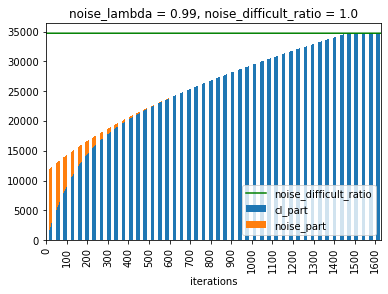

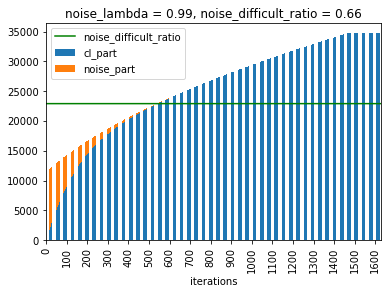

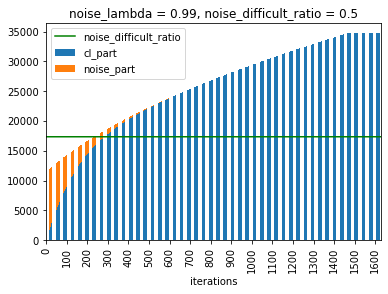

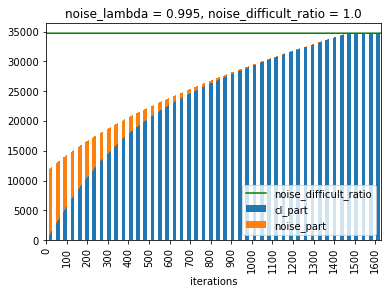

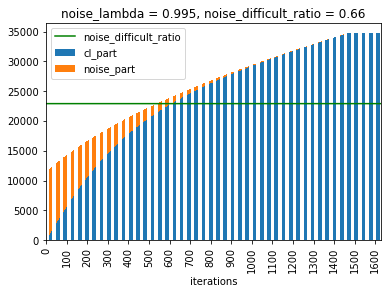

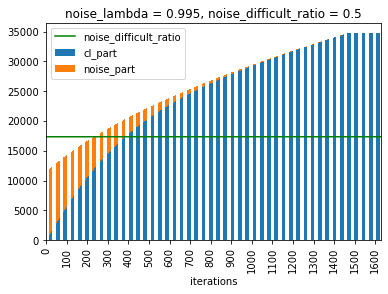

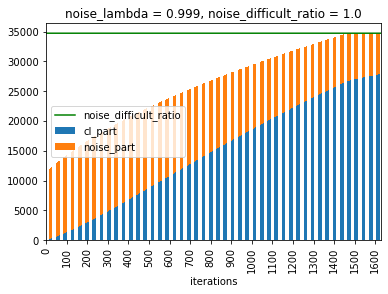

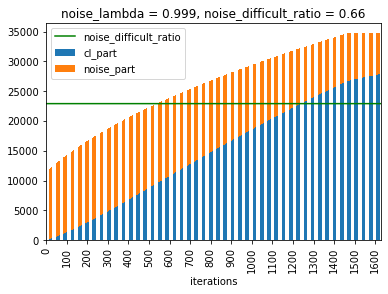

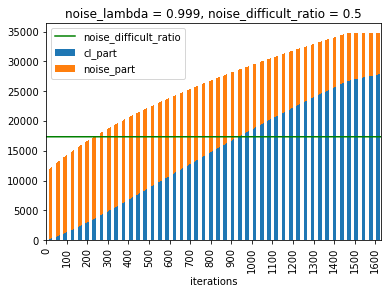

In [ ]:
# for illustrating the noise method
# visualize the number of noise samples and cl_scheduled samples changing with iterations
# take MSDialog as an example
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

total_sample_number = 34736
epochs = 3
batch_size = 64
noise_lambdas = [0.99, 0.995, 0.999]
noise_difficult_ratios = [1.0, 0.66, 0.50]
total_steps_number = math.ceil(total_sample_number*epochs//batch_size)
total_steps = list(range(0, total_steps_number))
curriculum_iterations = 0.9 * total_steps_number

cl_dict = {}
n_dict = {}
test = {}
for nl in noise_lambdas:
    for ndr in noise_difficult_ratios:
        key = "l_" + str(nl) + "_r_" + str(ndr)
        cl_dict[key] = []
        n_dict[key] = []
        for global_step in total_steps:
            noise_fraction = nl ** global_step
            cl_data_fraction = min(1, root_2(global_step, curriculum_iterations, 0.33))
            cl_scheduled_total = int(cl_data_fraction * total_sample_number)
            noise_part = int(cl_scheduled_total * noise_fraction)
            cl_part = cl_scheduled_total - noise_part 
            cl_dict[key].append(cl_part)
            n_dict[key].append(noise_part)


# plot the numbers as histograms
def plot_numbers(key, total_sample_number, plot_iter):
    _, nl, _, ndr = key.split('_')
    d = {"iterations": total_steps, "cl_part": cl_dict[key], "noise_part": n_dict[key], "noise_difficult_ratio": \
        [int(float(ndr)*total_sample_number)]*len(total_steps)}
    df = pd.DataFrame(data = d)
    title = "noise_lambda = " + str(nl) + ", noise_difficult_ratio = " + str(ndr)
    ax = df.plot(x='iterations', y = ["noise_difficult_ratio"], color = 'green')
    df.plot(x ='iterations', y = ['cl_part', 'noise_part'], kind = 'bar', stacked = True, title=title, ax = ax)
    plt.xticks(total_steps[0::plot_iter])
    plt.show()

# the iterations to be shown on the xticks
plot_iter = 100
for key in cl_dict.keys():
    plot_numbers(key, total_sample_number, plot_iter)
    

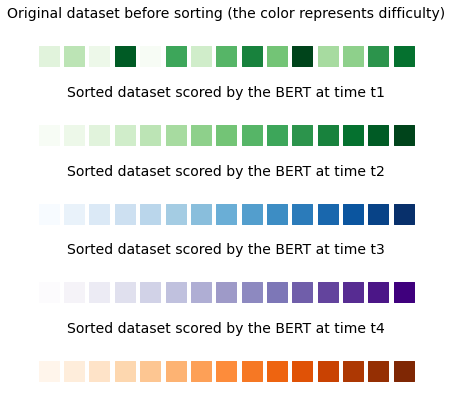

In [ ]:
# for illustrating the dynamic method
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(1, 16)*1.5
Y = [[] for i in range(5)]
for i in range(5):
  Y[i] = [5-i]*15
C = [3, 5, 2, 14, 1, 10, 4, 9, 12, 8, 15, 6, 7, 11, 13]
cmaps = ['Greens' ,'Blues', 'Purples', 'Oranges']
#edgecolors = ["g", "g", "b", "purple", "orange"]
fig, ax = plt.subplots(5, 1, figsize=(7, 7))
for i in range(5):
  ax[i].axis('off')
  if i == 0:
    ax[i].set_title('Original dataset before sorting (the color represents difficulty)', fontsize = 14)
    ax[i].scatter(X, Y[i], s=20**2, c=C, marker='s', cmap="Greens")#, vmin=2, vmax=15, edgecolors = 'grey') 
  else:
    ax[i].set_title("Sorted dataset scored by the BERT at time t{}".format(i), fontsize = 14)
    ax[i].scatter(X, Y[i], s=20**2, c=X, marker='s', cmap=cmaps[i-1])#, vmin=2, vmax=15, edgecolors = 'grey') 
plt.show()

# MSDialog Results

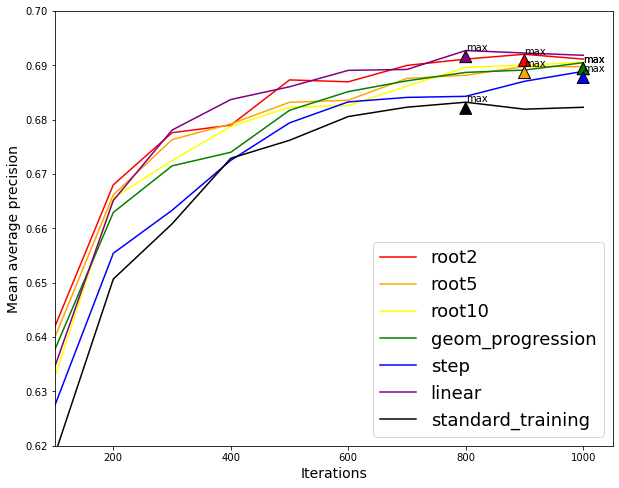

In [ ]:
# 1. basic cl experiment_1
# get the results of file 05-29
dataset_names = ["ms_v2"]
scoring_func_names = ['root2', 'root5', 'root10', 'geom_progression', 'step', 'linear','standard_training']
seeds = ['1', '2', '3', '4', '5']
path = "05-29"
res_1 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 10) 
res_df_1 = pd.DataFrame(res_1)
x = iterations(10, 100)
plot_with_max(res_df_1, title='', x=x, yb=0.62)

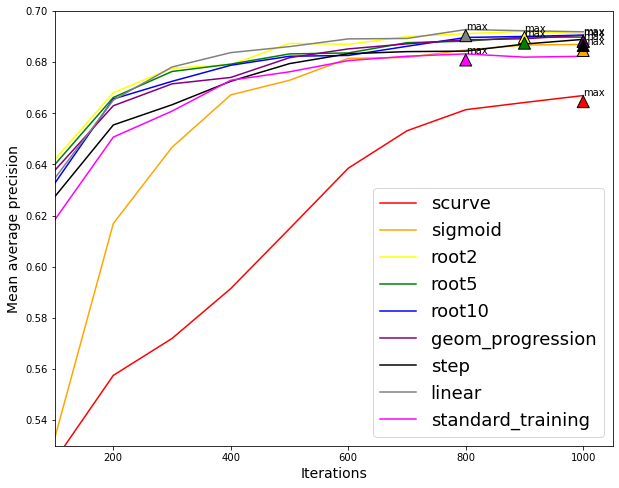

In [ ]:
# 1. basic cl experiment_2 with sigmoid and scurve functions
# get the results of file 06-07
dataset_names = ["ms_v2"]
scoring_func_names = ['scurve', 'sigmoid']
seeds = ['1', '2', '3', '4', '5']
path = "06-07"
res_2 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 10) 
res_2.update(res_1)
res_df_2 = pd.DataFrame(res_2)
x = iterations(10, 100)
plot_with_max(res_df_2, title="", x=x, yb=0.53) #title="MAP of different pacing functions",

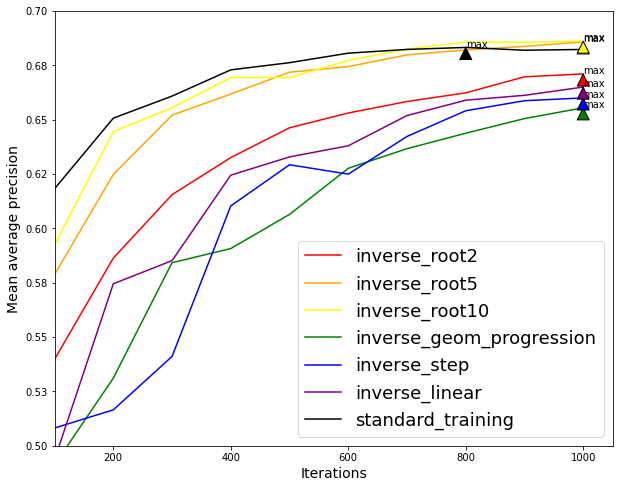

In [ ]:
# 1. basic cl experiment_3:inverse cl
# get the results of file 06-08
dataset_names = ["ms_v2"]
scoring_func_names = ['inverse_root2', 'inverse_root5', 'inverse_root10', 'inverse_geom_progression', 'inverse_step', 'inverse_linear']
seeds = ['1', '2', '3', '4', '5']
path = "06-08"
res_3 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 10) 
res_3['standard_training'] = res_1['standard_training']
res_df_3 = pd.DataFrame(res_3)
x = iterations(10, 100)
plot_with_max(res_df_3, title ="", x=x, yb = 0.5) #"MAP of inversed cl training"

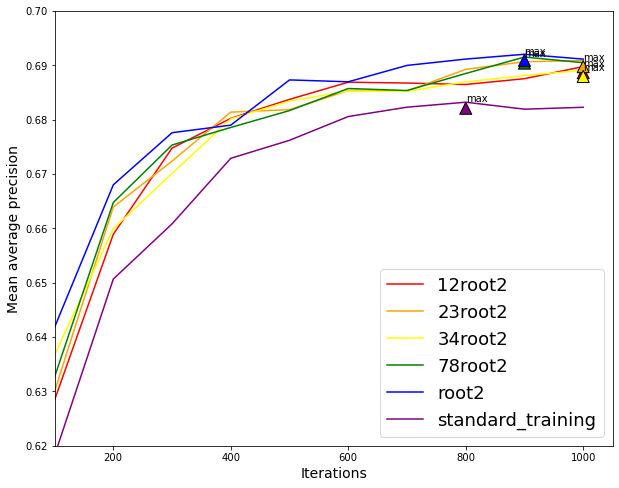

In [ ]:
# 2. noise method experiment_1: simpler noise method
# get the results of file 06-09, batch size = 64
dataset_names = ["ms_v2"]
scoring_func_names = ['12root2', '23root2', '34root2', '78root2']
seeds = ['1', '2', '3', '4', '5']
path = "06-09"
res_4 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 10) 
res_4['root2'] = res_1['root2']
res_4['standard_training'] = res_1['standard_training']
res_df_4 = pd.DataFrame(res_4)
x = iterations(10, 100)
plot_with_max(res_df_4, title ="" , x=x, yb=0.62)#"MAP of noised cl training"

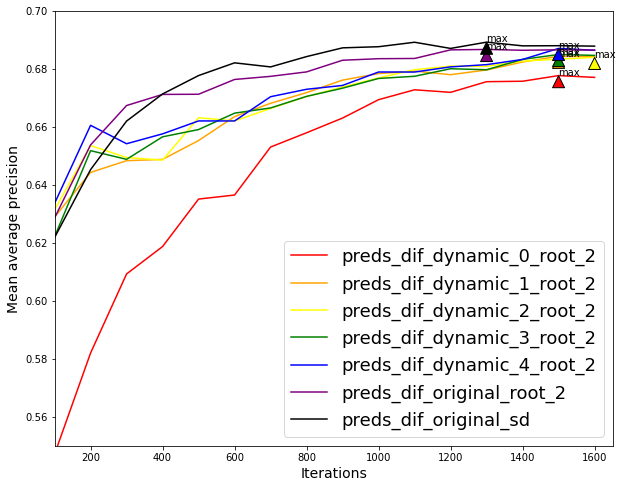

In [ ]:
# 3. dynamic rescoring method experiment_1: with different starting scoring file
# get the results of file 06-16, batch size = 64, epochs = 3
dataset_names = ["ms_v2"]
scoring_func_names = ['dynamic_0_root_2', 'dynamic_1_root_2', 'dynamic_2_root_2', 'dynamic_3_root_2', 'dynamic_4_root_2', 'original_root_2', 'original_sd'] #'root_2', 'standard_training', 
scoring_func_names = ['preds_dif_' + func for func in scoring_func_names]
seeds = ['1', '2', '3', '4', '5']
path = "06-16"
res_5 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 16) 
res_df_5 = pd.DataFrame(res_5)
x = iterations(16, 100)
plot_with_max(res_df_5, title="", x=x, yb=0.55, yh=0.7)#MAP of dynamic training

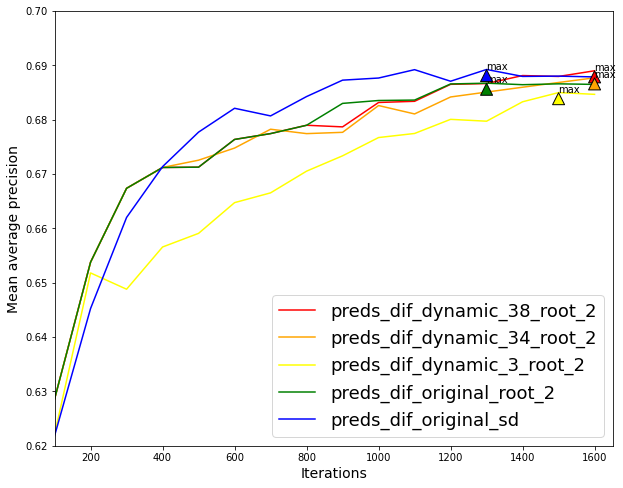

In [ ]:
# 3. dynamic rescoring method experiment_2: with different rescoring frequency
# get the results of file 07-08, batch size = 64, epochs = 3
dataset_names = ["ms_v2"]
scoring_func_names = ['dynamic_38_root_2', 'dynamic_34_root_2']
scoring_func_names = ['preds_dif_' + func for func in scoring_func_names]
seeds = ['1', '2', '3', '4', '5']
path = "07-08"
res_9 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 16) 
for key in ['dynamic_3_root_2','original_root_2','original_sd']:
    res_9['preds_dif_'+key] = res_5['preds_dif_' + key]
res_df_9 = pd.DataFrame(res_9)
x = iterations(16, 100)
plot_with_max(res_df_9, title="", x=x, yb=0.62, yh=0.70) #MAP of dynamic training

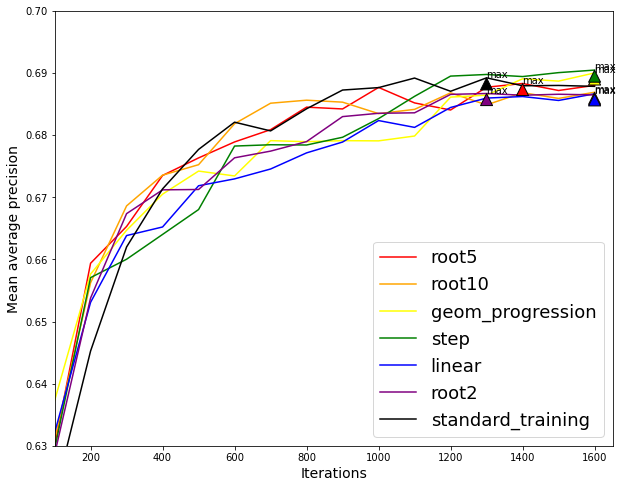

In [ ]:
# 3. dynamic rescoring method experiment_3: rerun baseline CL with a starting scoring file generated by fine-tuning batch_size=64
# get the results of file 06-23, batch size = 64, epochs = 3
dataset_names = ["ms_v2"]
scoring_func_names = ['root5', 'root10', 'geom_progression', 'step', 'linear' ]
seeds = ['1', '2', '3']
path = "06-23"
res_6 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 16) 
res_6['root2'] = res_5['preds_dif_original_root_2']
res_6['standard_training'] = res_5['preds_dif_original_sd']
res_df_6 = pd.DataFrame(res_6)
#print(res_df_6.columns)
#res_df_6.sort_values(['root2', 'root5', 'root10', 'geom_progression', 'step', 'linear','standard_training'], axis=1)
x = iterations(16, 100)
plot_with_max(res_df_6, title="", x=x, yb=0.63, yh=0.7)#MAP of different pacing functions bz=64

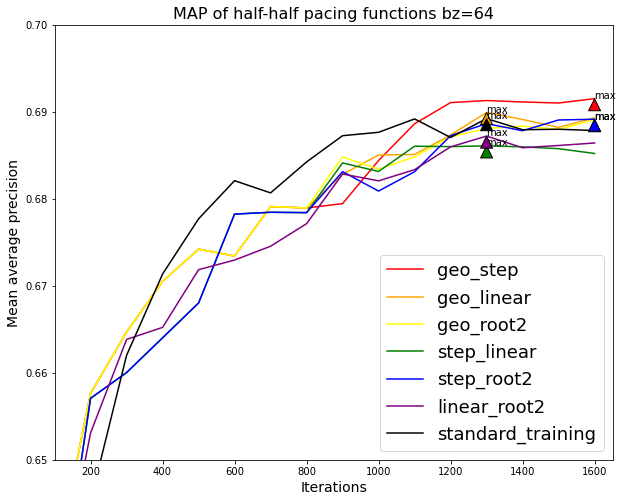

In [ ]:
# This method is not reported in the paper
# get the results of file 07-08, batch size = 64, epochs = 3
# half-half pacing-functions
dataset_names = ["ms_v2"]
scoring_func_names = ['geo_step', 'geo_linear', 'geo_root2', 'step_linear', 'step_root2', 'linear_root2']
seeds = ['1', '2', '3']
path = "07-08"
res_7 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 16) 
res_7['standard_training'] = res_5['preds_dif_original_sd']
res_df_7 = pd.DataFrame(res_7)
x = iterations(16, 100)
plot_with_max(res_df_7, title="MAP of half-half pacing functions bz=64", x=x, yb=0.65, yh=0.7)

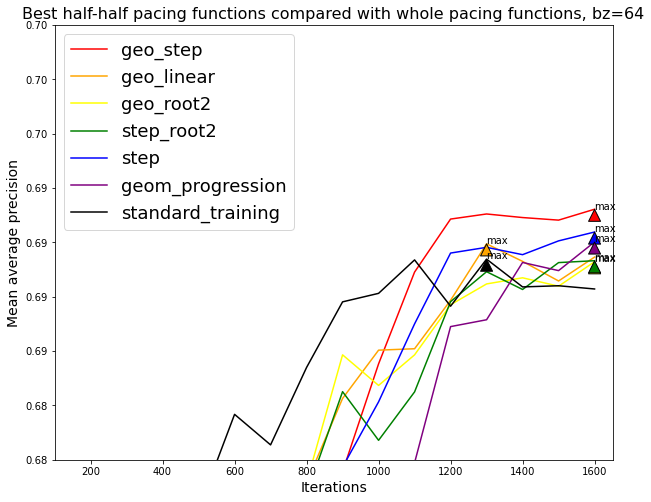

In [ ]:
# This method is not reported in the paper
# get the results of file 07-08, batch size = 64, epochs = 3
# half-half pacing-functions
dataset_names = ["ms_v2"]
scoring_func_names = ['geo_step', 'geo_linear', 'geo_root2', 'step_root2']
seeds = ['1', '2', '3']
path = "07-08"
res_8 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 16) 
res_8['step'] = res_6['step']
res_8['geom_progression'] = res_6['geom_progression']
res_8['standard_training'] = res_5['preds_dif_original_sd']
res_df_8 = pd.DataFrame(res_8)
x = iterations(16, 100)
plot_with_max(res_df_8, title="Best half-half pacing functions compared with whole pacing functions, bz=64", x=x, yb=0.68, yh=0.7)

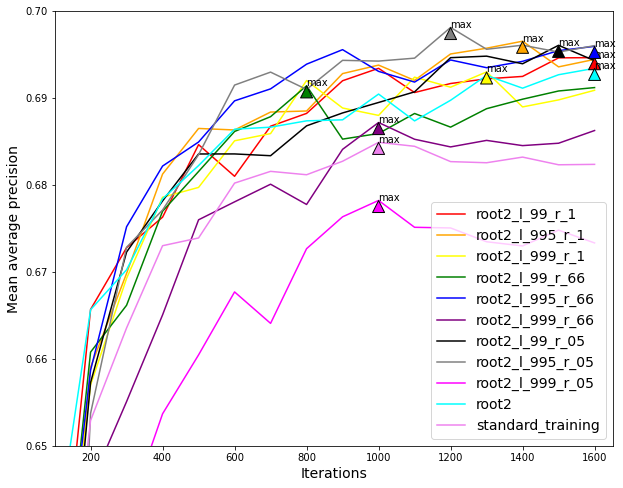

In [ ]:
# 2 the noise method experiment_2: shrinking noise
# get the results of file 07-28, batch size = 64, epochs = 3
# noise lambda
dataset_names = ["ms_v2"]
pf = "root2"
scoring_func_names = []
noise_lambda = ['99', '995', '999']
ratio = ['1', '66', '05']
for r in ratio:
    for nl in noise_lambda:
        scoring_func_names.append( pf + "_l_" + nl + '_r_' + r)
scoring_func_names += ["root2", "standard_training"] 
seeds = ["1", "2", "3"]
path = "07-28"
res_9 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 16) 
# res_9["root_2"] = res_5["preds_dif_original_root_2"]
# res_9["standard_training"] = res_5["preds_dif_original_sd"]
res_df_9 = pd.DataFrame(res_9)
x = iterations(16, 100)
plot_with_max(res_df_9, title="", x=x, yb=0.65, yh=0.7, legend_size = 14)#noise lambda, bz=64

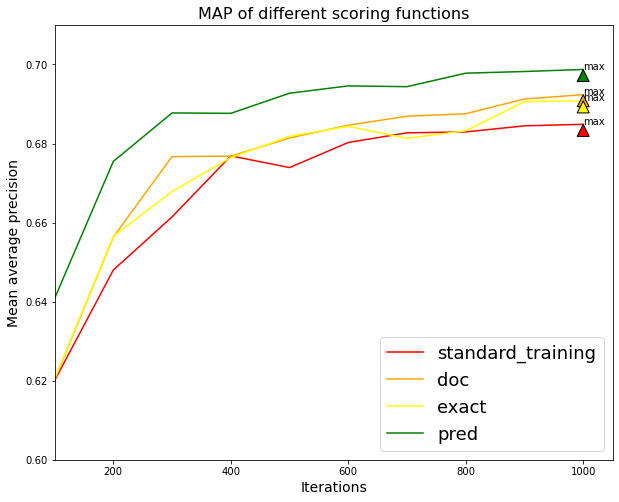

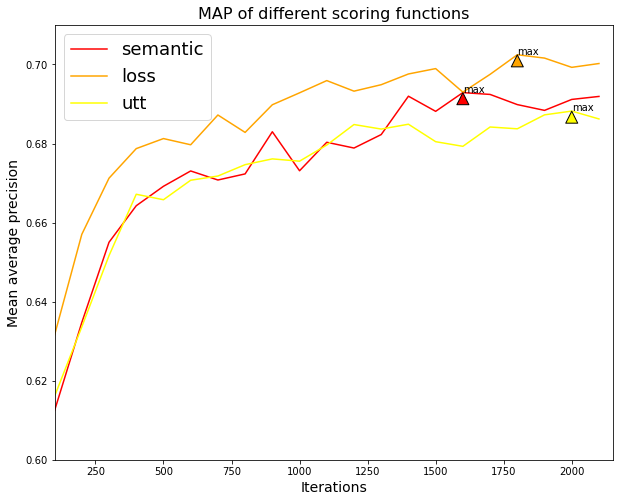

In [ ]:
# Not reported in paper
# other scoring functions other than model output
# get the results of file 06-01
dataset_names = ["ms_v2"]
scoring_func_names = [['standard_training', 'doc', 'exact', 'pred'], ['semantic', 'loss','utt']]
length = [10, 21]
seeds = ['1']
path = "06-01"
for i in range(2):
    res_6 = get_all_results(path, dataset_names, scoring_func_names[i], seeds, length[i]) 
    res_df_6 = pd.DataFrame(res_6)
    if i == 0:
        x = iterations(10, 100)
    else:
        x = iterations(21, 100)
    plot_with_max(res_df_6, title = "MAP of different scoring functions", x=x, yb=0.60, yh=0.71)

# MANtIS Results

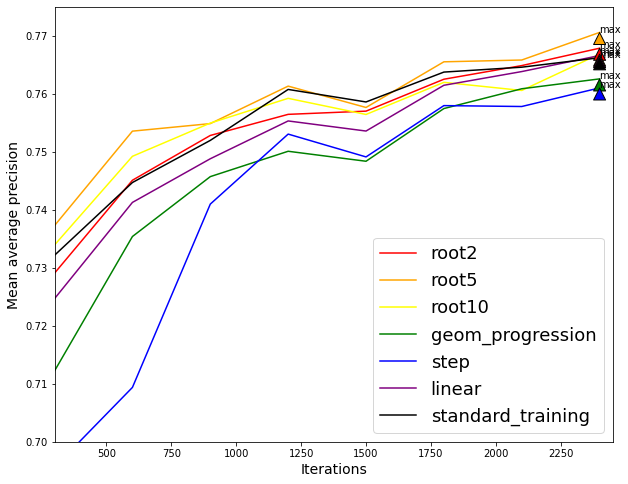

In [ ]:
# get the results of file 08-09
dataset_names = ["mantis_10"]
scoring_func_names = ['root2', 'root5','root10','geom_progression', 'step', 'linear', 'standard_training']
seeds = ['1_8_6w', '2_8_6w', '3_8_6w']
path = "08-09"
res_3 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 8) 
res_df_3 = pd.DataFrame(res_3)
x = iterations(8, 300)
plot_with_max(res_df_3, title='', x=x, yb=0.70, yh = 0.775)#MAP of different pacing functions with eval_size=60000

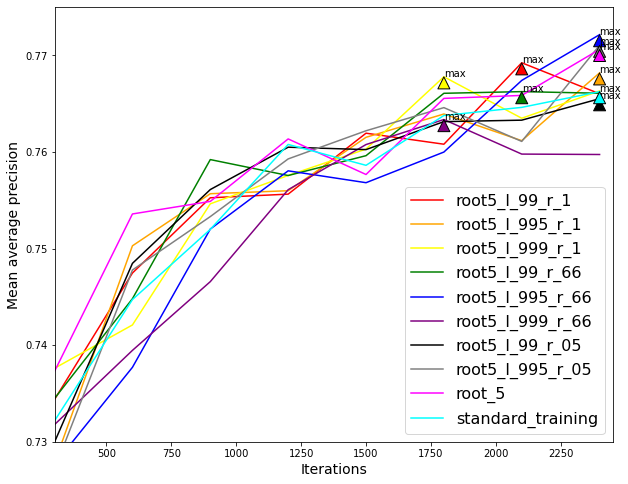

In [ ]:
# get the results of file 08-13
dataset_names = ["mantis"]
pf = "root5"
scoring_func_names = []
noise_lambda = ['99', '995', '999']
ratio = ['1', '66', '05']
for r in ratio:
    for nl in noise_lambda:
        if r == '05' and nl == '999':
            continue
        scoring_func_names.append( pf + "_l_" + nl + '_r_' + r)
seeds = ["1", "2", "3"]
path = "08-13"
res_4 = get_all_results(path, dataset_names, scoring_func_names, seeds, length = 8) 
res_4["root_5"] = res_3["root5"]
res_4["standard_training"] = res_3["standard_training"]
res_df_4 = pd.DataFrame(res_4)
x = iterations(8, 300)
plot_with_max(res_df_4, title='', x=x, yb=0.73, yh = 0.775,legend_size=16) # MAP of different pacing functions with eval_size=60000